## Import library

In [105]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import lightgbm as lgb
import json

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

from matplotlib.patches import Patch, Rectangle
import matplotlib.style as style

# Metadata analysis

In [ ]:
def plot_count_sample(metadata, figsize, title):
    num_of_samples = metadata.shape[0]
    num_s = []
    num_r = []
    num_nan = []
    for idx, c in enumerate(metadata.columns):
        num_r.append(metadata[c].value_counts()[1])
        num_s.append(metadata[c].value_counts()[0])
        num_nan.append(num_of_samples - num_r[idx] - num_s[idx])
    num_amr = pd.DataFrame([num_r, num_s, num_nan], index=['R', 'S', 'NaN']).T
    num_amr.index = metadata.columns
    num_amr.plot(kind='bar', stacked=True, color=['C3', 'C0', 'k'], figsize=figsize)
    plt.legend(bbox_to_anchor=(1., 1.02)); plt.title(title)
    plt.ylabel('Count'); plt.show()

### E. coli metadata

In [14]:
Ecoli_metadata = pd.read_csv('Ecoli/metadata_final.csv')
for c in Ecoli_metadata.columns[2:]:
    Ecoli_metadata[c] = Ecoli_metadata[c].map(lambda x: 1 if x in ['R', 'I'] else 0 if x=='S' else x)
Ecoli_metadata.drop(columns=['Isolate', 'Year', 'TZP'], inplace=True)
Ecoli_metadata = Ecoli_metadata.reindex(sorted(Ecoli_metadata.columns), axis=1)
Ecoli_metadata

,AMC,AMP,AMX,CET,CIP,CTX,CTZ,CXM,GEN,TBM,TMP
0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1648,0.0,1.0,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1649,0.0,1.0,NaN,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
1650,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
1651,1.0,1.0,NaN,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0


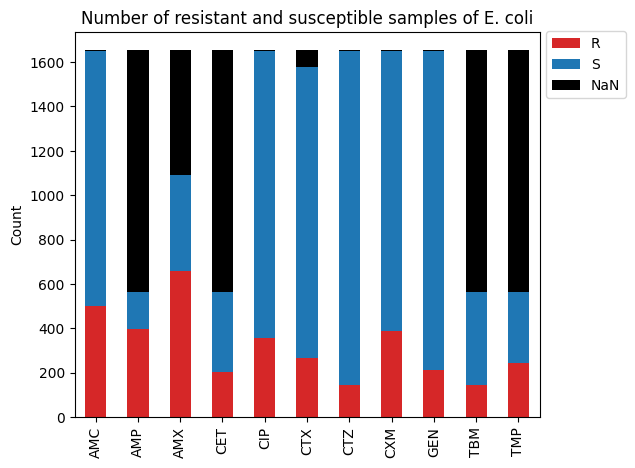

In [16]:
plot_count_sample(Ecoli_metadata, (6, 5),
                  title='Number of resistant and susceptible samples of E. coli')

### K. pneumoniae metadata

In [27]:
Kp_metadata = pd.read_csv('Kp_data/Kpmetadata_final.csv')
for c in Kp_metadata.columns:
    Kp_metadata[c] = Kp_metadata[c].map(lambda x: 1 if x in ['R', 'I'] else 0 if x=='S' else x)
drop_col = ['Isolate', 'Year', 'amikacin', 'meropenem']
for c in Kp_metadata.columns[2:]:
    if Kp_metadata.shape[0] - Kp_metadata[c].value_counts(dropna=False)[np.nan] < 500:      # drop antibiotics with num of samples is less than 500
        drop_col.append(c)
Kp_metadata = Kp_metadata.drop(columns=drop_col)

mapping_name = {'ampicillin@sulbactam':'AMS', 'aztreonam':'AZT', 'cefazolin':'CZL', 'cefepime':'FEP', 'cefoxitin':'FOX', 'ceftazidime':'CAZ',
                'ceftriaxone':'CTR', 'cefuroxime@sodium':'CXM', 'ciprofloxacin':'CIP', 'gentamicin':'GEN', 'imipenem':'IPM', 'levofloxacin':'LVX',
                'nitrofurantoin':'NIT', 'piperacillin@tazobactam':'TZP', 'tetracycline':'TCY', 'tobramycin':'TOB', 'trimethoprim@sulfamethoxazole':'SXT'}

Kp_metadata.columns = Kp_metadata.columns.map(mapping_name)
Kp_metadata

,AMS,AZT,CZL,FEP,FOX,CAZ,CTR,CXM,CIP,GEN,IPM,LVX,NIT,TZP,TCY,TOB,SXT
0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0
1,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0
2,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,1.0,NaN,1.0,NaN,1.0,0.0
3,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0
4,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2329,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,0.0,1.0,1.0
2330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


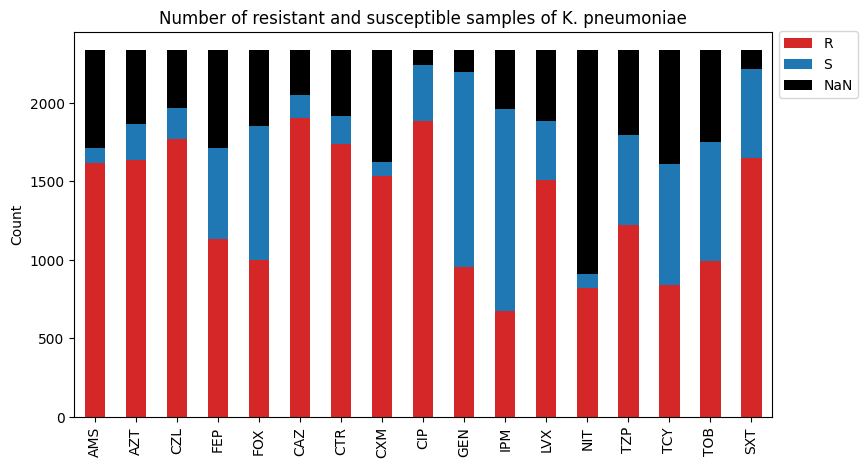

In [29]:
plot_count_sample(Kp_metadata, (9, 5),
                  title='Number of resistant and susceptible samples of K. pneumoniae')

## Pre-process data

### E. coli data

In [54]:
# KmerDNA data
kmer_dna = pd.DataFrame(np.load('Ecoli/AllKmerDNA-002.npy'))
kmer_dna = kmer_dna.T.drop_duplicates(keep='first').T.astype('int8')

# KmerProtein data
kmer_protein = pd.DataFrame(np.load('Ecoli/AllKmerProtein-001.npy'))
kmer_protein = kmer_protein.T.drop_duplicates(keep='first').T.astype('int8')

# PanPred data
panpred = pd.DataFrame(np.load('Ecoli/PanPredPangenomeMatrix.npy'))
panpred = panpred.T.drop_duplicates(keep='first').T.astype('int8')

# PanCore
coregene = pd.DataFrame(np.load('Ecoli/coregenes.npy')).astype('int8')
coregene.columns = [f'C{i}' for i in range(coregene.shape[1])]
coregene = coregene.T.drop_duplicates(keep='first').T
coregene = coregene.where(coregene!=0, np.nan)

# AMR Kmer
amr_kmer = pd.DataFrame(np.load('Ecoli/KmerAMRGenePanV9.npy'))
amr_kmer.columns = [f'K{i}' for i in range(amr_kmer.shape[1])]
amr_kmer = amr_kmer.T.drop_duplicates(keep='first').T.astype('int8')

# PA matrix (presence and absence matrix)
pa_matrix = pd.read_table('Ecoli/gene_presence_absence.Rtab').T
pa_matrix.columns = pa_matrix.values[0]
pa_matrix.drop(index=['Gene'], inplace=True)
pa_matrix.reset_index(drop=True, inplace=True)
pa_matrix = pa_matrix.where(pa_matrix==0, 1).T.drop_duplicates(keep='first').T.astype('int8')

In [81]:
print('Shape of KmerDNA:', kmer_dna.shape)
print('Shape of KmerProtein:', kmer_protein.shape)
print('Shape of PanPred:', panpred.shape)
print('Shape of PanCore:', coregene.shape)
print('Shape of AMR Kmer:', amr_kmer.shape)
print('Shape of PA matrix:', pa_matrix.shape)

Shape of KmerDNA: (1653, 15435)
Shape of KmerProtein: (1653, 52011)
Shape of PanPred: (1653, 13456)
Shape of PanCore: (1653, 22995)
Shape of AMR Kmer: (1653, 10057)
Shape of PA matrix: (1653, 9518)


In [56]:
panka_all = pd.concat([coregene, amr_kmer, pa_matrix], axis=1)
panka_all = panka_all.T.drop_duplicates(keep='first').T
panka_all

,C0,C1,C2,C3,C5,C6,C7,C8,C11,C12,...,groups_21863,groups_21865,groups_21866,groups_21869,groups_21870,groups_21874,groups_21875,groups_21876,groups_21877,groups_21878
0,12,10,15,8,17,2,4,13,7,15,...,0,0,0,0,0,0,0,0,0,0
1,12,10,15,8,17,2,4,13,7,15,...,0,0,0,0,0,0,0,0,0,0
2,12,10,15,8,17,2,4,13,7,15,...,0,0,0,0,0,0,0,0,0,0
3,12,10,15,8,17,2,4,13,7,15,...,0,0,0,0,0,0,0,0,0,0
4,12,10,15,8,17,2,4,13,7,15,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648,12,10,15,8,17,2,4,13,7,15,...,0,0,0,0,0,0,0,0,0,0
1649,12,10,15,8,17,2,4,13,7,15,...,0,0,0,0,0,0,0,0,0,0
1650,12,10,15,8,17,2,4,13,7,15,...,0,0,0,0,0,0,0,0,0,0
1651,12,10,15,8,17,2,4,13,7,15,...,0,0,0,0,0,0,0,0,0,0


### K. pneumoniae data

In [80]:
# KmerDNA
Kp_KmerDNA = pd.DataFrame(np.load('Kp_data/KpFullKmer/DNAKmer.npy')).astype('int8').T.drop_duplicates(keep='first').T

# KmerProtein
Kp_KmerProtein = pd.DataFrame(np.load('Kp_data/KpFullKmer/ProteinKmer.npy')).astype('int8').T.drop_duplicates(keep='first').T

# PanPred
Kp_PanPred = pd.DataFrame(np.load('Kp_data/KpPanPredPangenome.npy')).astype('int8').T.drop_duplicates(keep='first').T

# PanCore
Kp_Core = pd.DataFrame(np.load('Kp_data/KpPatricCoreGeneLabelEncoderMatTop2kTrue.npy')).T.drop_duplicates(keep='first').T.astype('int8')
Kp_Core = Kp_Core.where(Kp_Core != 0, np.nan)
# AMR Kmer
Kp_AMR_Kmer = pd.DataFrame(np.load('Kp_data/KpPatricKmerEncoderAMRGenes.npy')).T.drop_duplicates(keep='first').T.astype('int8')

# PA matrix
Kp_pa_matrix = pd.DataFrame(np.load('Kp_data/KppantaRtab.npy'))
Kp_pa_matrix = Kp_pa_matrix.where(Kp_pa_matrix==0, 1).T.drop_duplicates(keep='first').T

In [89]:
print('Shape of KmerDNA:', Kp_KmerDNA.shape)
print('Shape of KmerProtein:', Kp_KmerProtein.shape)
print('Shape of PanPred:', Kp_PanPred.shape)
print('Shape of PanCore:', Kp_Core.shape)
print('Shape of AMR Kmer:', Kp_AMR_Kmer.shape)
print('Shape of PA matrix:', Kp_pa_matrix.shape)

Shape of KmerDNA: (2334, 157249)
Shape of KmerProtein: (2334, 126110)
Shape of PanPred: (2334, 31441)
Shape of PanCore: (2334, 17233)
Shape of AMR Kmer: (2334, 17995)
Shape of PA matrix: (2334, 14304)


In [90]:
Kp_panka_all = pd.concat([Kp_Core, Kp_AMR_Kmer, Kp_pa_matrix], axis=1, ignore_index=True)
Kp_panka_all = Kp_panka_all.T.drop_duplicates(keep='first').T
Kp_panka_all

,0,1,2,3,4,5,6,7,8,9,...,49522,49523,49524,49525,49526,49527,49528,49529,49530,49531
0,22.0,20.0,20.0,1.0,1.0,19.0,22.0,18.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,20.0,1.0,22.0,22.0,19.0,1.0,18.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,20.0,1.0,22.0,22.0,19.0,1.0,18.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22.0,20.0,20.0,1.0,1.0,19.0,22.0,18.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,20.0,1.0,1.0,1.0,19.0,1.0,18.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2329,22.0,20.0,20.0,22.0,22.0,19.0,22.0,18.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2330,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2331,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2332,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Define functions

In [98]:
# combine features and labels -> drop missing labels -> drop duplicates rows
def combine_data(strain, metadata, data):
    df = pd.concat([data, metadata[strain]], axis=1).dropna(subset=[strain])
    df = pd.concat([df.iloc[:, :-1].T.drop_duplicates(keep='first').T, df.iloc[:, -1].astype('int8')], axis=1)
    return df.reset_index(drop=True)

In [101]:
# run GridSearchCV: one antibiotic with various data
def run_gridSearchCV(antibiotic, method, metadata, all_data):
    type_data = []
    best_mean_AUC = []; best_mean_F1 = []
    folds_AUC = []; folds_F1 = []
    params_best_AUC = []; params_best_F1 = []
    t = time.time()
    for key in all_data.keys():
        t1 = time.time()
        print(f'\t Running in data {key}...')
        data = combine_data(antibiotic, metadata, all_data[key])

        if method == 'GBDT':
            params = {
                'random_state':10,   
            }
            clf = GradientBoostingClassifier(**params)
            param_grid = {
                'max_features': ['sqrt', 'log2', 1000],
                'n_estimators': [300, 600, 5000],
                'max_depth': [3, 10],
                'min_samples_leaf': [1, 5]
            }
        elif method == 'LGBM':
            params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'device': 'cpu',
            'n_estimators':100,
            'n_jobs': 2,
            'force_col_wise': True,
            'verbose': -1
            }
            clf = lgb.LGBMClassifier(**params)
            param_grid = {
                'max_depth': [5, 7, 9, 11],
                'max_bin': [2, 3, 4, 8],
                'num_leaves': [31, 63],
                'min_child_samples':[5, 20]
            }
        else:
            raise(KeyError(f'Method {method} is not supported!'))
        
        # Grid Search CV
        grid_search = GridSearchCV(
            estimator=clf,
            param_grid=param_grid,
            cv=5,
            n_jobs=5,
            scoring={'AUC':'roc_auc', 'F1_score':'f1'},
            refit='AUC',
            verbose=0
        )
        grid_search.fit(X=data.iloc[:, :-1], y=data.iloc[:, -1])
        
        # save cv results
        cv_results = grid_search.cv_results_
        arg_best_AUC = np.argmin(cv_results['rank_test_AUC'])
        arg_best_F1 = np.argmin(cv_results['rank_test_F1_score'])

        type_data.append(key + f' {method}')
        best_mean_AUC.append(cv_results['mean_test_AUC'][arg_best_AUC])
        best_mean_F1.append(cv_results['mean_test_F1_score'][arg_best_F1])
        temp_AUC = []; temp_F1 = []
        for i in range(5):
            temp_AUC.append(cv_results[f'split{i}_test_AUC'][arg_best_AUC])
            temp_F1.append(cv_results[f'split{i}_test_F1_score'][arg_best_F1])
        folds_AUC.append(temp_AUC); folds_F1.append(temp_F1)
        params_best_AUC.append(cv_results['params'][arg_best_AUC])
        params_best_F1.append(cv_results['params'][arg_best_F1])

        print('\t \t Best mean test AUC =', cv_results['mean_test_AUC'][arg_best_AUC], '; Best mean test F1 =', cv_results['mean_test_F1_score'][arg_best_F1])
        print(f'\t \t ---Running time: {(time.time() - t1) / 60} mins---')

    summary = pd.DataFrame([type_data, best_mean_AUC, best_mean_F1, folds_AUC, folds_F1, params_best_AUC, params_best_F1],
                index=['Type data', 'Best mean AUC', 'Best mean F1', '5-folds AUC', '5-folds F1', 'Params best AUC', 'Params best F1']).T
    print(f'---Time running: {(time.time() - t) / 60} mins---\n')
    return summary

In [95]:
# run GridSearchCV for various antibiotics
def run_various_antibiotic(antibiotics, method, metadata, all_data):
    summary = pd.DataFrame([], 
                columns=['Type data', 'Best mean AUC', 'Best mean F1', '5-folds AUC', '5-folds F1', 'Params best AUC', 'Params best F1', 'Antibiotic'])
    for antibiotic in antibiotics:
        print(f'Run in antibiotic {antibiotic}')
        temp = run_gridSearchCV(antibiotic, method, metadata, all_data)
        temp['Antibiotic'] = antibiotic
        summary = pd.concat([summary, temp], axis=0, ignore_index=True)
    return summary

### Run LightGBM model

In [103]:
Ecoli_all_data = {'KmerDNA':kmer_dna, 'KmerProtein':kmer_protein,
                  'PanPred':panpred, 'PanKA (AMR Kmer)':amr_kmer, 'PanKA (all)':panka_all}

In [106]:
all_summary_Ecoli = run_various_antibiotic(antibiotics=Ecoli_metadata.columns,
                                           method='LGBM',
                                           metadata=Ecoli_metadata,
                                           all_data=Ecoli_all_data)

Run in antibiotic AMC
	 Running in data KmerDNA...
	 	 Best mean test AUC = 0.719420312031203 ; Best mean test F1 = 0.47614527571288745
	 	 ---Running time: 2.988092565536499 mins---
	 Running in data KmerProtein...


In [ ]:
all_summary_Ecoli.to_csv('all_summary_Ecoli.csv', index=None)

In [ ]:
Kp_all_data = {'KmerDNA':Kp_KmerDNA, 'KmerProtein':Kp_KmerProtein,
                'PanPred':Kp_PanPred, 'PanKA (AMR Kmer)':Kp_AMR_Kmer, 'PanKA (all)':Kp_panka_all}

In [ ]:
all_summary_Kp = run_various_antibiotic(antibiotics=Kp_metadata.columns,
                                        method='LGBM',
                                        metadata=Kp_metadata,
                                        all_data=Kp_all_data)

In [ ]:
all_summary_Kp.to_csv('all_summary_Kp.csv', index=None)